In [151]:
#
# IonQ, Inc., Copyright (c) 2024,
# All rights reserved.
# Use in source and binary forms of this software, without modification,
# is permitted solely for the purpose of activities associated with the IonQ
# Hackathon at Quantum Korea hosted by SKKU at Hotel Samjung and only during the
# June 21-23, 2024 duration of such event.
#
import logging
import pickle
import shutil
import tempfile
from datetime import datetime
from pathlib import Path
from typing import List

import git
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
from ionqvision.ansatze import VariationalAnsatz
from ionqvision.modules import QuantumModule
from ionqvision.modules.trainable_module import TrainableModule
from ionqvision.scq_client import IonQSCQClient
from qiskit.quantum_info import SparsePauliOp

MODELS_DIR = "trained_models"


class SubmissionError(Exception):
    """Class for exceptions raised while making submissions"""


class BinaryMNISTClassifier(TrainableModule):
    """
    A hybrid quantum-classical classifier for distinguishing between two types
    of handwritten digits in the MNIST database.

    The model architecture is detailed in the challenge description.
    """
    def __init__(
            self,
            numDesiredParameters: int,
            encoder: VariationalAnsatz,
            trainable_ansatz: VariationalAnsatz,
            obs: List[SparsePauliOp],
            backend=None,
            shots: int=1000,
            dropout_prob: float=0.5
        ):
        self.num_pc = 6

        height, width = 28, self.num_pc
        in_dim = height * width

        super().__init__()
        self.latent_vec_encoder = nn.Sequential(*[
            nn.Linear(in_dim, numDesiredParameters), 
            nn.Dropout(dropout_prob),
            nn.Sigmoid()
        ])
        #print("DEBUG/n-----------------------------------------")
        #print(encoder.parameters)
        #print(trainable_ansatz.parameters)
        self.quantum_layer = QuantumModule(encoder, trainable_ansatz, obs, backend, shots)
        self.prediction_head = nn.Sequential(*[
            nn.Linear(len(obs), 1), 
            nn.Dropout(dropout_prob),
            nn.Sigmoid()
        ])

    def forward(self, x):
        x = x.reshape((x.shape[0], -1))
        #print(1)
        #print(x)
        x = self.latent_vec_encoder(x)
        #print(2)
        #print(x.shape)
        #print(x)
        x = self.quantum_layer(x)
        #print(3)
        #print(x)
        x = self.prediction_head(x)
        return x.squeeze()

    @classmethod
    def load_model(self, path):
        with tempfile.TemporaryDirectory() as tempdir:
            shutil.unpack_archive(path, tempdir, "zip") 

            encoder = VariationalAnsatz.from_file(f"{tempdir}/encoder.qpy")
            trainable_ansatz = VariationalAnsatz.from_file(f"{tempdir}/ansatz.qpy")
            with open(f"{tempdir}/observables.pkl", "rb") as f:
                features = pickle.load(f)
            features = list(SparsePauliOp.from_list(obs) for obs in features)

            model = BinaryMNISTClassifier(encoder, trainable_ansatz, features)
            model.load_state_dict(torch.load(f"{tempdir}/model_weights.pt"))
        return model

    def get_train_test_set(self, train_size=1_000, test_size=100):
        """
        Get sample sets of 0-1 MNIST images of size `train_size` and
        `test_size` for training and testing your model.

        .. NOTE:

            This method compresses the raw images by projecting them onto their
            leading `self.num_pc` principal components using PCA.

            Make sure you train your model on these compressed images!
        """
        mnist = self.load_binary_mnist()

        for split, sz in zip(["train", "test"], [train_size, test_size]):
            idx = torch.randperm(len(mnist[split]))[:sz]
            mnist[split].data, mnist[split].targets = mnist[split].data[idx].float(), mnist[split].targets[idx]

            _, _, V = torch.pca_lowrank(mnist[split].data, q=self.num_pc, niter=10)
            mnist[split].data = torch.matmul(mnist[split].data, V)
        return mnist["train"], mnist["test"]

    def load_binary_mnist(self):
        """
        Load all ``DIGIT1`` and ``DIGIT2`` images of the MNIST dataset.

        OUTPUT:
            
            A dictionary with keys `"train"` and `"test"` mapping to
            corresponding `torchvision.datasets` objects.
        """
        DIGIT1 = 0
        DIGIT2 = 1

        preproc = tv.transforms.Compose([
            tv.transforms.ToTensor(),
        ])
        mnist = dict()
        for split in ["train", "test"]:
            mnist[split] = tv.datasets.MNIST("./mnist-" + split, train=(split == "train"), download=True, transform=preproc)
        
            idx = (mnist[split].targets == DIGIT1) | (mnist[split].targets == DIGIT2)
            mnist[split].data, mnist[split].targets = mnist[split].data[idx], mnist[split].targets[idx]

            mnist[split].targets = mnist[split].targets != DIGIT1
        return mnist

    def save_model(self, path="", path_to_repo=""):
        """
        Serialize `self` and save ZIP archive to `path`.

        When no `path` is provided, the file name is generated automatically
        using the current commit's hash value.
        """
        if Path(path).is_dir() or not path:
            timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S')
            model = f"model_{timestamp}"
            path = Path(path_to_repo).joinpath(path).joinpath(model)

        with tempfile.TemporaryDirectory() as tempdir:
            torch.save(self.state_dict(), f"{tempdir}/model_weights.pt")
            self.quantum_layer.encoder.to_file(f"{tempdir}/encoder.qpy")
            self.quantum_layer.trainable_ansatz.to_file(f"{tempdir}/ansatz.qpy")
            with open(f"{tempdir}/observables.pkl", "wb") as f:
                pickle.dump([obs.to_list() for obs in self.quantum_layer.quantum_features], f)
            shutil.make_archive(path, "zip", tempdir)
        return f"{path}.zip"

    def submit_model_for_grading(self, path_to_repo="", client=None):
        """
        Submit `self` for grading.

        We recommend using this method at the *root* level of the cloned
        challenge repo. However, you may optinally specify a `path_to_repo`
        root.

        .. NOTE:

            This method stores a ZIP archive describing `self` in the 
            `trained_models` directory and it pushes a new `git` commit to the
            remote repository.
        """
        Path(MODELS_DIR).mkdir(exist_ok=True)
        path = self.save_model(MODELS_DIR, path_to_repo)
        full_path = Path(path).resolve()
        client = client or IonQSCQClient()
        try:
            submission_data = client.create_submission(file_path=str(full_path))
            logging.info("Success! Submitted %s for grading!", path)
            return submission_data
        except Exception as err:
            raise SubmissionError(f"Failed to submit model for grading from path '{full_path}'") from err

    def visualize_batch(self, batch=None):
        """
        Visualize a batch of images using PyPlot.

        If no `batch` is given, generate a random batch of 20 training images.
        """
        if batch is None:
            mnist = self.load_binary_mnist()
            batch, _ = next(iter(torch.utils.data.DataLoader(mnist["train"], batch_size=32, shuffle=True)))

        if len(batch.shape) == 3:
            batch = batch[:, None, :, :]
        plt.imshow(np.transpose(tv.utils.make_grid(batch)/2 + 0.5, (1, 2, 0)))


In [152]:
from ionqvision.ansatze.ansatz_library import BrickworkLayoutAnsatz

class QCNNAnsatz(VariationalAnsatz):
    r"""
    Implement the Quantum Convolutional Network Ansatz (QCNN) as described in
    :cite:t:`2019:qcnn`.

    The quasi-local unitary $U_i$'s are entangling two-qubit gates with $6$
    variational parameters.
    They are laid out in a brickwork pattern with ``filter_depth`` layers.

    The pooling operations are implemented by two-qubit controlled rotations,
    with $2$ variational parameters.

    The circuit starts with ``num_qubits`` active qubits and then half the
    remaining qubits are discarded after each pooling operation until only a
    single active qubit remains. This final qubit is measured and the result is
    used for binary classification.
    """
    class ConvolutionBrickwork(BrickworkLayoutAnsatz):
        """
        Implement the convolution filters for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, num_layers, prefix=None, qubits=None, initial_state=None):
            super().__init__(num_qubits, num_layers, blk_sz=3, prefix=prefix, qubits=qubits, initial_state=initial_state)
        
        def two_qubit_block(self, theta, q1, q2):
            conv_op = QuantumCircuit(2, name="CONV")
            conv_op.ry(theta[0], 0)
            conv_op.ry(theta[1], 1)
            conv_op.rxx(theta[2], 0, 1)
            self.append(conv_op.to_instruction(), [q1, q2])

    class PoolingLayer(BrickworkLayoutAnsatz):
        """
        Implement the pooling layer for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, prefix=None, qubits=None):
            super().__init__(num_qubits, 1, blk_sz=1, prefix=prefix, qubits=qubits)
    
        def two_qubit_block(self, theta, q1, q2):
            pool_op = QuantumCircuit(2, name="POOL")
            pool_op.crz(theta[0], 1, 0)
            self.append(pool_op.to_instruction(), [q1, q2])

    def __init__(self, num_qubits, filter_depth=2, initial_state=None):
        num_layers = int(log(num_qubits, 2))
        if abs(log(num_qubits, 2) - num_layers) > 1e-6:
            raise ValueError("num_qubits must be a power of 2")

        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)

        for k in range(num_layers):
            qubits = list(range(0, num_qubits, 2**k))
        
            conv = QCNNAnsatz.ConvolutionBrickwork(num_qubits, filter_depth, prefix="C" + str(k), qubits=qubits)
            self.compose(conv, inplace=True)
            
            pool = QCNNAnsatz.PoolingLayer(num_qubits, prefix="P" + str(k), qubits=qubits)
            self.compose(pool, inplace=True)
            if (k == 0):
                training4 = ParameterVector("R_layer_" + str(k), totalSize - numParams)
                self.rx(np.pi * training4[0], 0)
                self.rx(np.pi * training4[1], 1)
                self.rx(np.pi * training4[2], 2)
                self.rx(np.pi * training4[3], 3)


In [179]:
from ionqvision.ansatze.ansatz_library import AngleEncoder
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit import Parameter, ParameterVector

numParams = 4
totalSize = 8

qc = QuantumCircuit(totalSize)
x = ParameterVector("theta", numParams)

[qc.ry(np.pi * xi, qbt) for qbt, xi in enumerate(x)]
[qc.rx(np.pi * xi, qbt) for qbt, xi in enumerate(x)]
[qc.h(qbt + numParams) for qbt in range(numParams)]

qc.cx(0,3)
qc.cx(0,2) 
qc.cx(1,3)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)

encoder = AngleEncoder(num_qubits=8)
newEncoder = encoder.from_quantum_circuit(qc)







tempAnsatz = QCNNAnsatz(num_qubits=4)
newAnsatz = qc.compose(tempAnsatz, qubits=[4, 5, 6, 7])

# Measure the expectation value of X_0, Y_0, Z_0
quantum_features = [
    SparsePauliOp(["IIIIIIIX"]), 
    SparsePauliOp(["IIIIIIIY"]),
    SparsePauliOp(["IIIIIIIZ"])
]



In [180]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [181]:
#from ionqvision.modules import BinaryMNISTClassifier
classifier = BinaryMNISTClassifier(numParams, newEncoder, newAnsatz, quantum_features); classifier

BinaryMNISTClassifier(
  (latent_vec_encoder): Sequential(
    (0): Linear(in_features=168, out_features=4, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (quantum_layer): QuantumModule()
  (prediction_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

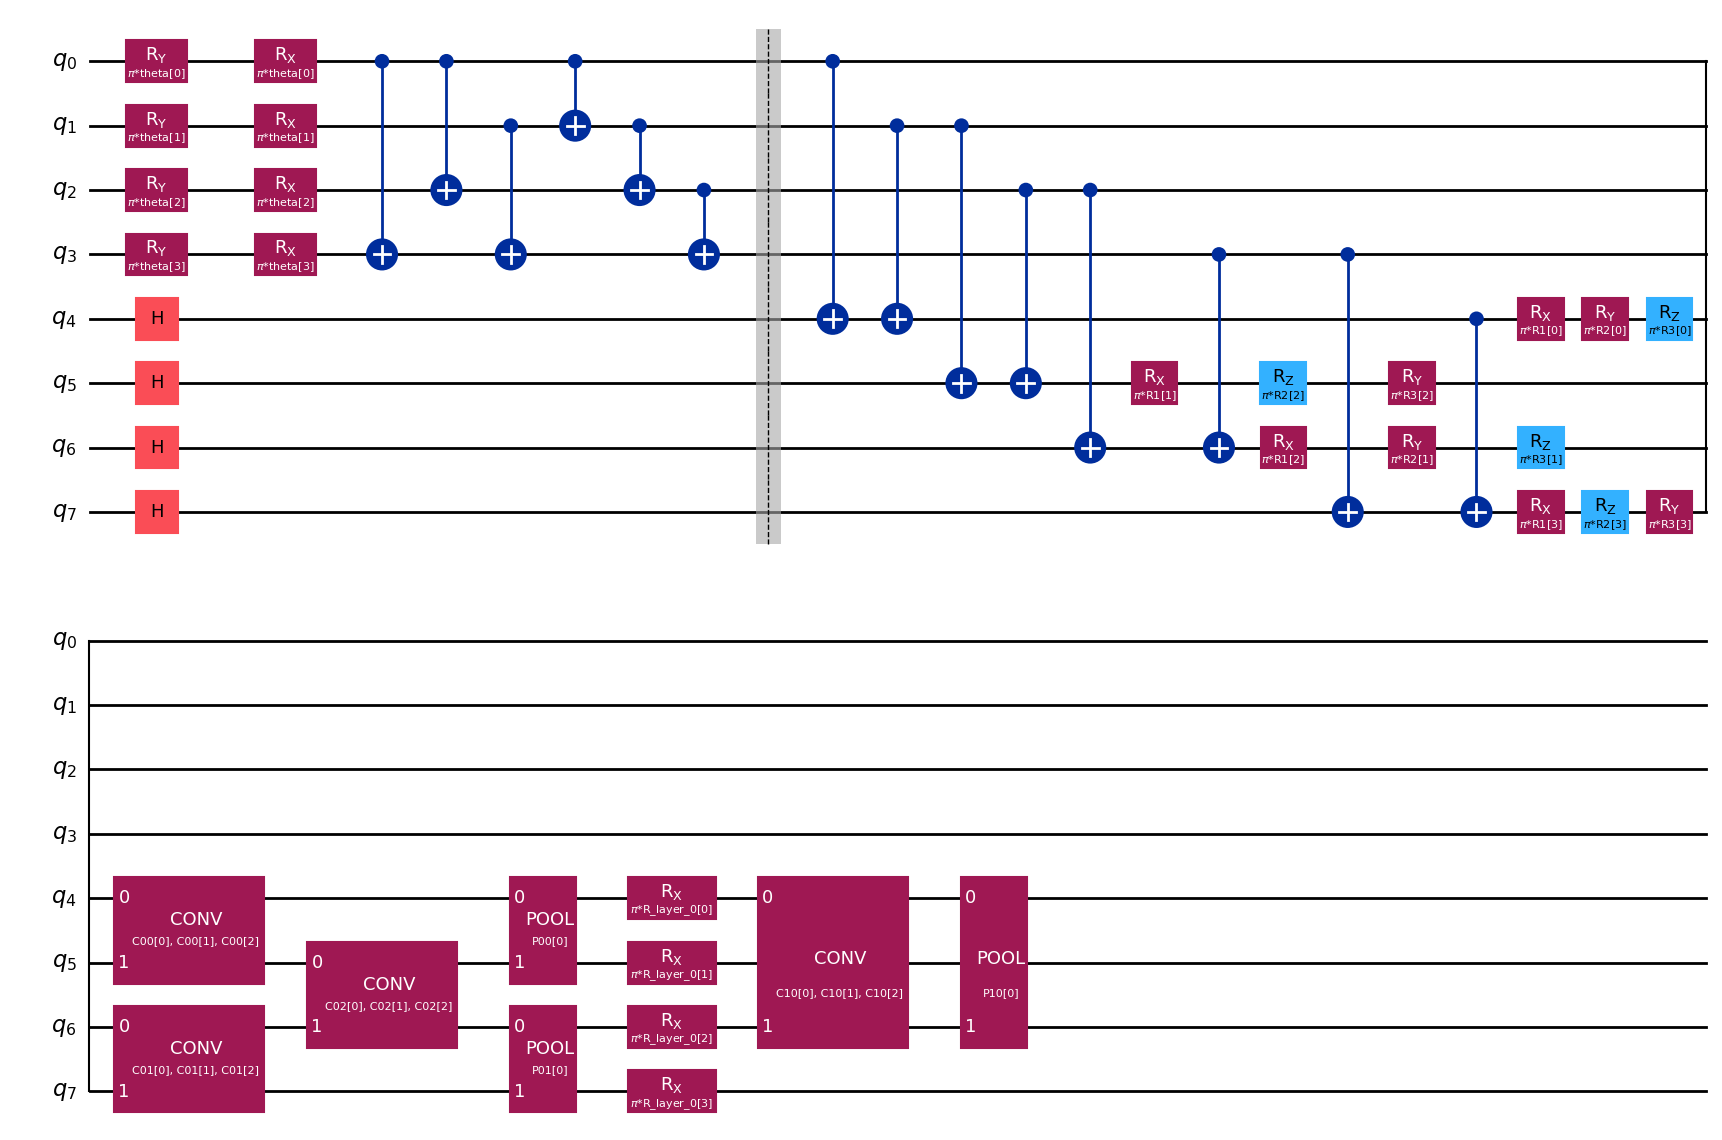

In [182]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

epoch:   1 | loss: 1.019
lr: 0.1000 | processed     1/   13 batches per epoch in 81.32s (1.13s forward / 64.30s backward)
Model achieved 49.000%  accuracy on TRAIN set.
Model achieved 46.000%  accuracy on TEST set.

epoch:   1 | loss: 0.875
lr: 0.1000 | processed     2/   13 batches per epoch in 161.25s (1.16s forward / 62.80s backward)
Model achieved 49.500%  accuracy on TRAIN set.
Model achieved 46.000%  accuracy on TEST set.

epoch:   1 | loss: 0.833
lr: 0.1000 | processed     3/   13 batches per epoch in 240.52s (1.16s forward / 62.11s backward)
Model achieved 49.500%  accuracy on TRAIN set.
Model achieved 46.000%  accuracy on TEST set.

epoch:   1 | loss: 0.805
lr: 0.1000 | processed     4/   13 batches per epoch in 328.01s (0.99s forward / 64.47s backward)
Model achieved 49.500%  accuracy on TRAIN set.
Model achieved 46.000%  accuracy on TEST set.

epoch:   1 | loss: 0.783
lr: 0.1000 | processed     5/   13 batches per epoch in 388.43s (0.89s forward / 49.52s backward)
Model achi

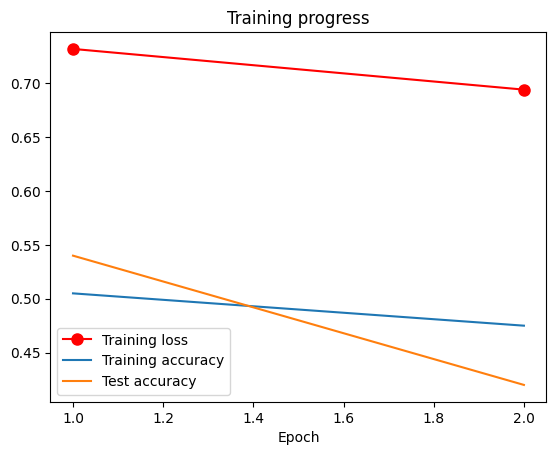

In [183]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=200, test_size=50)

# Configure model training hyperparameters
config = {
    "epochs": 2,
    "lr": 0.1,
    "batch_size": 16,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 1,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

In [184]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()
client = IonQSCQClient(session=session)

submission_data = classifier.submit_model_for_grading(client=client)
message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

client.await_autograder_result(submission_id=submission_id)

AttributeError: 'QuantumCircuit' object has no attribute 'to_file'